# CLIP-Dissect
**Keywords**: Neuron-level Interpretability, Network Dissection

**About the dataset**:

* We use the standard [CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) here which contains 60k RGB images of size $32\times 32$ belonging to 100 classes.

**Agenda**:

* In this programming challenge, we will answer the following questions.
  * Let's dissect resnet 50 layers 1, 2, 3, and 4 similar to what we did on the last layer neuron.
      - Use CIFAR100 probing dataset, 10k concept set, and wpmi similarity
      - Does the neuron description match the highly activated images? How many of them describe well / not so well but relevant / not accurate?  
      - Please think of a way to manage / save the result for future analysis.  


**Note:**
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.

In [1]:
# !!DO NOT EDIT!!
!git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect
!pip install ftfy regex

Cloning into 'CLIP-dissect'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 104 (delta 12), reused 15 (delta 9), pack-reused 80
Receiving objects: 100% (104/104), 15.94 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (33/33), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.2 MB/s eta 0:00:00


In [2]:
import os
os.chdir('CLIP-dissect')

In [3]:
import torch
import pandas as pd

import clip
import utils
import data_utils
import similarity

import matplotlib
from matplotlib import pyplot as plt

import csv

In [4]:
# Settings
clip_name = 'ViT-B/16'
target_name = 'resnet50'
# target_layers = ['layer1', 'layer2', 'layer3', 'layer4']
target_layers = ['layer4']
d_probe = 'cifar100_train'
concept_set = 'data/10k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

First, run the below code to save all the labels as a csv to download and compare.

In [ ]:
for layer in target_layers:
  # Set layer
  target_layer = layer

  # Run CLIP-Dissect
  utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                        d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                        device = device, pool_mode=pool_mode, save_dir = save_dir)

  with open(concept_set, 'r') as f:
      words = (f.read()).split('\n')

  pil_data = data_utils.get_data(d_probe)

  save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                    target_layer = target_layer, d_probe = d_probe,
                                    concept_set = concept_set, pool_mode=pool_mode,
                                    save_dir = save_dir)

  target_save_name, clip_save_name, text_save_name = save_names
  similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                  text_save_name, similarity_fn, device=device)

  neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1]

  labels = []
  for j, orig_id in enumerate(neurons_to_check):
      vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
      labels.append([words[int(ids[0])]])

  with open('labels_' + layer, 'w') as f:

      # using csv.writer method from CSV package
      write = csv.writer(f)

      write.writerows(labels)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 2048/2048 [00:08<00:00, 231.36it/s]


torch.Size([2048, 9894])


Next, run the below code for each layer, changing the target_layer each time to get all activating images for all neurons. Split up the neurons if the number of neurons per layer gets too large. Currently, I split by 200 neurons on each run of this code.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 2048/2048 [00:09<00:00, 225.10it/s]


torch.Size([2048, 9894])


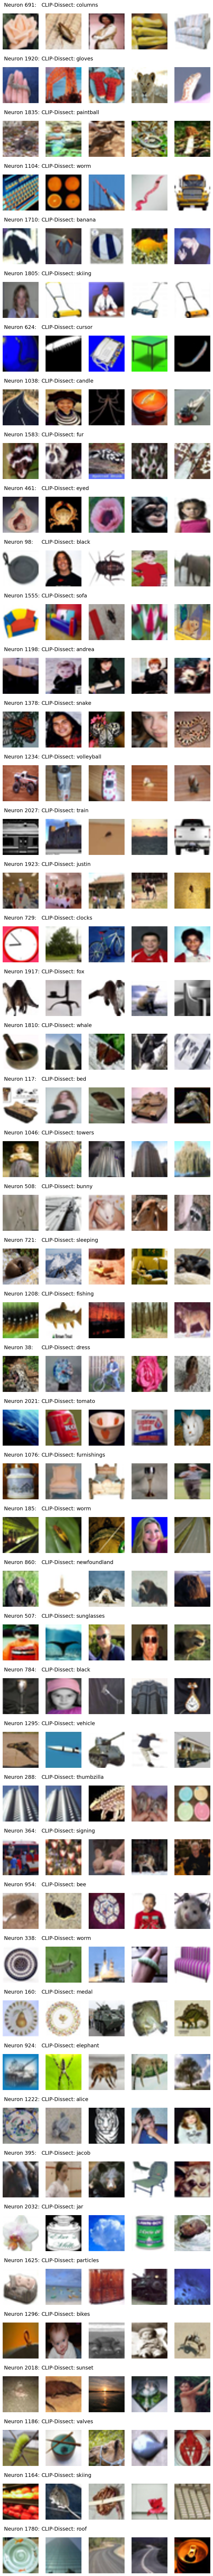

In [15]:
# Set layer
target_layer = 'layer1'

# Run CLIP-Dissect
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                      d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                      device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                text_save_name, similarity_fn, device=device)

# Visualize
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1]#[0:200]
font_size = 14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
labels = []
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
    labels.append([words[int(ids[0])]])

    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')

plt.show()


---
---